## <center>**Deteksi spam email menggunakan word2vec**</center>

In [29]:
import numpy as np
import pandas as pd

## <center> Observing Data</center>

In [30]:
df=pd.read_csv('spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


**Memahami tipe data kolom dalam dataframe**

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


Penjelasan
1. `<class 'pandas.core.frame.DataFrame'>`: objek yang yangperiksa adalah sebuah dataframe dari Pandas.

2. `RangeIndex: 5171 entries, 0 to 5170`: dataframe memiliki indeks dengan jangkauan (range) dari 0 hingga 5170 dengan total 5171 entri (baris).

3. `Data columns (total 4 columns)`: terdapat 4 kolom (atribut) dalam dataframe.

4. `#   Column      Non-Null Count  Dtype`:
   - `#`: No indeks kolom (mulai dari 0).
   - `Column`: Nama kolom.
   - `Non-Null Count`: Jumlah nilai non-null (non-kosong) dalam kolom tersebut. Ini memberi tahu berapa banyak entri yang tidak kosong dalam kolom.
   - `Dtype`: Tipe data dari kolom tersebut.

5. `dtypes: int64(2), object(2)`: dalam dataframe ini terdapat dua kolom dengan tipe data `int64` (bilangan bulat) dan dua kolom dengan tipe data `object` (biasanya digunakan untuk data berjenis teks).

6. `memory usage: 161.7+ KB`: Ini menunjukkan perkiraan penggunaan memori untuk dataframe, yang dihitung sebagai sekitar 161.7 kilobyte.

**Memeriksa apakah data mengandung nilai null (NaN)**

In [32]:
df.isna().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

**Membuat perbandingan antara email spam dan email biasa menggunakan countplot dari seaborn**

<AxesSubplot: xlabel='label', ylabel='count'>

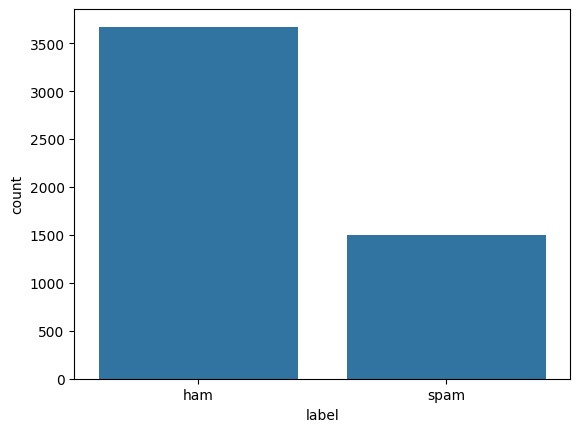

In [33]:
import seaborn as sns
sns.countplot(x="label",data=df)

## <center> Data Cleaning </center>

In [34]:
print(df['text'][0])

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


In [35]:
!pip install contractions

In [36]:
import contractions
# untuk mengembangkan kontraksi dlm bahasa inggris ke bentuk asli. contoh : I'll to "I will"
from tqdm import tqdm
# tqdm package is used to track the progress of work. It displays the percentage of loop done.
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
# download stopwords dalam bahasa inggris
stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
processed_emails=[]
for i in tqdm(df['text']):
    #menghapus tag html
    i=re.sub('(<[\w\s]*/?>)',"",i)
    i=contractions.fix(i)
    #menghapus karakter khusus, sehingga yang tersisa hanya huruf, angka, dan spasi
    i=re.sub('[^a-zA-Z0-9\s]+',"",i)
    #menghapus semua digit(angka)
    i=re.sub('\d+',"",i)
    #mengubah menjadi huruf kecil, menghapus kata" jika tidak ada distopwords dan jika panjangnya kurang dari 3
    processed_emails.append(" ".join([j.lower() for j in i.split() if j not in stopwords and len(j)>=3]))

 12%|█▏        | 601/5171 [00:00<00:04, 1015.75it/s]

100%|██████████| 5171/5171 [00:08<00:00, 583.54it/s]


In [38]:
processed_df=pd.DataFrame({'text':processed_emails,'Spam/Ham':list(df['label_num'])})
processed_df.head()

,text,Spam/Ham
0,subject enron methanol meter follow note gave ...,0
1,subject hpl nom january see attached file hpln...,0
2,subject neon retreat around wonderful time yea...,0
3,subject photoshop windows office cheap main tr...,1
4,subject indian springs deal book teco pvr reve...,0


## <center> Data Preparation </center>

In [39]:
X=processed_df['text']
Y=processed_df['Spam/Ham']
# memisahkan data, 20% untuk testing dan 80% untuk training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.20)

In [40]:
from gensim.models import Word2Vec

**Membuat data untuk melatih model word2vec**

In [41]:
words_in_sentences=[]
for i in tqdm(x_train):
    words_in_sentences.append(i.split())

100%|██████████| 4136/4136 [00:00<00:00, 30620.49it/s]


In [42]:
model = Word2Vec(sentences=words_in_sentences, vector_size=200,workers=-1)

**Jumlah kata dalam Kosakata yang digunakan dalam pelatihan model Word2Vec.**

In [43]:
kosakata=list(model.wv.key_to_index.keys())
print(len(kosakata))

7494


**Average Word2Vec for converting a given Sentence into numerical vector.**


In [44]:
def avg_w2vec(kalimat):
    hasil_transformasi = []
    for kalimat_teks in tqdm(kalimat):
        hitung = 0 # menghitung berapa banyak kata yang ada dalam kalimat yg termasuk dlm kosakata
        vektor = np.zeros(200) # vektor 0 dgn panjang 200 yg akan digunakan utk menghitung rata" vektor kata" dlm kalimat
        for kata in kalimat_teks.split(): # mengambil setiap kata dalam kalimat (dibagi berdasar spasi)
            if kata in kosakata:
                vektor += model.wv.get_vector(kata) # vektor kata tsb akan diambil dr model word2vec dan ditambahkan ke 'vektor'
                hitung += 1 # jumlah kata yang valid akan ditambahkan ke 'hitung'
        if hitung != 0:
            vektor / hitung
            hasil_transformasi.append(vektor)
        else:
            print(kalimat_teks)
    return np.array(hasil_transformasi)

merepresentasi numerik dari setiap kalimat dalam `x_train` dan `x_test` sebagai vektor rata-rata

In [45]:
x_train_hasil_transformasi=avg_w2vec(x_train)
x_test_hasil_transformasi=avg_w2vec(x_test)

  3%|▎         | 107/4136 [00:01<00:58, 68.84it/s]

100%|██████████| 1035/1035 [00:06<00:00, 161.24it/s]


In [46]:
from gensim.models import Word2Vec

# Save the trained Word2Vec model
model.save("word2vec_model.bin")

# Load the saved Word2Vec model
loaded_model = Word2Vec.load("word2vec_model.bin")

# Now you can use loaded_model for word embeddings

### **Menggunakan Algoritma K-Nearest Neighbors untuk memprediksi apakah email tsb Spam atau tidak.**

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
grid_params = { 'n_neighbors' : [1,3,5,7,9,11],
               'metric' : ['manhattan','euclidean','minkowski']}
knn=KNeighborsClassifier()
clf = RandomizedSearchCV(knn, grid_params, random_state=0,n_jobs=-1,verbose=1) # menjalankan pencarian parameter pada model KNN. Randomize utk ceri parameter terbaiknya
clf.fit(x_train_hasil_transformasi,y_train) # model knn diberi data pelatihan

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['manhattan', 'euclidean',
                                                   'minkowski'],
                                        'n_neighbors': [1, 3, 5, 7, 9, 11]},
                   random_state=0, verbose=1)

In [48]:
clf.best_params_

{'n_neighbors': 1, 'metric': 'euclidean'}

In [49]:
clf.best_score_ #skor terbaik yang ditemukan selama pencarian parameter

0.8936196250927338

In [50]:
clf.cv_results_ # berisi informasi ttg hasil pencarian parameter (skor model utk setiap kombinasi parameter yang diuji)

{'mean_fit_time': array([0.08729844, 0.03851624, 0.03753648, 0.03650956, 0.03472886,
        0.04067988, 0.04219146, 0.03769021, 0.03771806, 0.03492532]),
 'std_fit_time': array([0.04874426, 0.00610614, 0.00646654, 0.00653891, 0.00400112,
        0.01169547, 0.01115821, 0.00702513, 0.00801936, 0.0035722 ]),
 'mean_score_time': array([1.46913881, 0.22434716, 0.201863  , 0.20893822, 0.14289007,
        0.95265436, 1.02548695, 0.16916785, 0.14849296, 0.19274817]),
 'std_score_time': array([0.47113601, 0.02763467, 0.01477223, 0.01153275, 0.00624145,
        0.02567034, 0.01003329, 0.00882655, 0.00708711, 0.01744352]),
 'param_n_neighbors': masked_array(data=[3, 1, 5, 9, 5, 9, 5, 9, 11, 7],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_metric': masked_array(data=['manhattan', 'euclidean', 'euclidean', 'euclidean',
                    'minkowski', 'manhattan', 'manhatt

# <center> Model Evaluation </center>

* fpr : false positive rate
* tpr : true positive rate

In [51]:
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
train_fpr,train_tpr,thresholds=roc_curve(y_train,clf.predict_proba(x_train_hasil_transformasi)[:,1])
test_fpr,test_tpr,thresholds=roc_curve(y_test,clf.predict_proba(x_test_hasil_transformasi)[:,1])

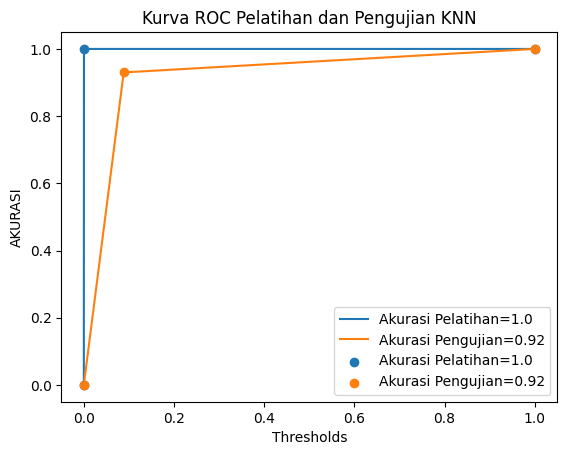

In [52]:
import matplotlib.pyplot as plt

# Membuat plot untuk kurva ROC pada data pelatihan dan pengujian
plt.plot(train_fpr, train_tpr, label="Akurasi Pelatihan=" + str(round(auc(train_fpr, train_tpr), 2)))
plt.plot(test_fpr, test_tpr, label="Akurasi Pengujian=" + str(round(auc(test_fpr, test_tpr), 2)))

# Menambahkan titik-titik pada kurva ROC
plt.scatter(train_fpr, train_tpr, label="Akurasi Pelatihan=" + str(round(auc(train_fpr, train_tpr), 2)))
plt.scatter(test_fpr, test_tpr, label="Akurasi Pengujian=" + str(round(auc(test_fpr, test_tpr), 2)))
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("AKURASI")
plt.title("Kurva ROC Pelatihan dan Pengujian KNN")
plt.show()

### **Confusion Matrix and Classification Report**

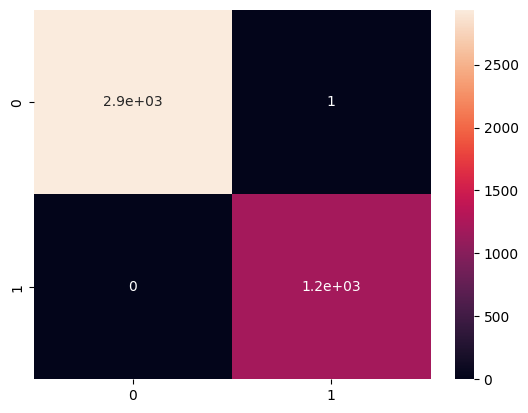

In [53]:
sns.heatmap(confusion_matrix(y_train,clf.predict(x_train_hasil_transformasi)),annot=True)
plt.show()

In [54]:
print(classification_report(y_train,clf.predict(x_train_hasil_transformasi)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2937
           1       1.00      1.00      1.00      1199

    accuracy                           1.00      4136
   macro avg       1.00      1.00      1.00      4136
weighted avg       1.00      1.00      1.00      4136



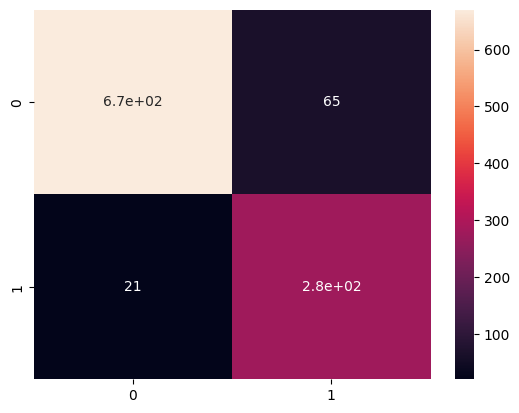

In [55]:
sns.heatmap(confusion_matrix(y_test,clf.predict(x_test_hasil_transformasi)),annot=True)
plt.show()

In [56]:
print(classification_report(y_test,clf.predict(x_test_hasil_transformasi)))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       735
           1       0.81      0.93      0.87       300

    accuracy                           0.92      1035
   macro avg       0.89      0.92      0.90      1035
weighted avg       0.92      0.92      0.92      1035

